In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import torch

In [2]:
def get_csv_files_from_dir(dir):
    files = []
    for file in os.listdir(dir):
        f = os.path.join(dir, file)
        if os.path.isfile(f) and f.endswith('.csv'):
            files.append(f)
    return files

In [3]:
def transform_cp_data(data, error, velocity, acceleration):
    data = data.sort_values(by=['rs_id', 'id', 'time']).reset_index(drop=True)
    
    data = data[
        ['rs_id', 'id', 'time', 'x', 'y', 'z'] + \
        (['x_err', 'y_err', 'z_err'] if error else []) + \
        (['v_x_est', 'v_y_est', 'v_z_est'] if velocity else []) + \
        (['a_x_est', 'a_y_est', 'a_z_est'] if acceleration else [])
    ]

    data = data.dropna()

    return data

In [4]:
def get_track(data, rs_id, id, t_min=None, t_max=None, drop_ids=True):
    track = data[(data['rs_id'] == rs_id) & (data['id'] == id)]
    if t_min is not None:
        track = track[track['time'] >= t_min]
    if t_max is not None:
        track = track[track['time'] <= t_max]
    if drop_ids:
        track = track.drop(columns=['rs_id', 'id'])
    return track

In [5]:
def get_tracks_timeranges_intersection(track_1, track_2):
    t_min_1, t_max_1 = track_1['time'].min(), track_1['time'].max()
    t_min_2, t_max_2 = track_2['time'].min(), track_2['time'].max()

    t_min, t_max = max(t_min_1, t_min_2), min(t_max_1, t_max_2)
    return t_min, t_max

In [6]:
def extend_track_with_zeros(track, track_length, zeros_placement='start'):
    if track.size(0) == 0 or track_length == 0:
        return None
    if track.size(0) >= track_length:
        return track[:track_length, :]
    
    zeros = torch.zeros(track_length - track.size(0), track.size(1))
    
    if zeros_placement == 'start':
        return torch.cat((zeros, track), 0)
    elif zeros_placement == 'end':
        return torch.cat((track, zeros), 0)

    return None

In [7]:
def extend_track_with_linear_interpolation(track, track_length):
    if track.size(0) < 2 or track_length == 0:
        return None
    if track.size(0) >= track_length:
        return track[:track_length, :]

    while track.size(0) != track_length:
        diffs = track[:, 0].diff(1, 0)

        point_1_idx = torch.argmax(diffs).item()
        point_2_idx = point_1_idx + 1

        new_point = torch.lerp(track[point_1_idx, :], track[point_2_idx, :], 0.5).unsqueeze(0)

        track = torch.cat((track[:point_1_idx+1, :], new_point, track[point_2_idx:, :]), 0)

    return track

In [8]:
def generate_siamese_data_from_cp_tracks(track_1, track_2, track_length, drop_last=False):
    if track_1.shape[1] != track_2.shape[1]:
        raise RuntimeError(f'Tracks must have the same number of columns, got {track_1.shape[1]} and {track_2.shape[1]} instead.')
    
    x = torch.empty((0, 2, track_1.shape[1], track_length))
    
    t_min, t_max = get_tracks_timeranges_intersection(track_1, track_2)
    
    current_t_max = t_max

    break_flag = False
    while current_t_max > t_min:
        # crop tracks to current max time
        track_1 = track_1[track_1['time'] < current_t_max]
        track_2 = track_2[track_2['time'] < current_t_max]

        # get last parts of tracks
        track_1_part = track_1.tail(track_length)
        track_2_part = track_2.tail(track_length)

        # remove last parts of tracks from original tracks
        track_1 = track_1.drop(track_1.tail(track_length).index)
        track_2 = track_2.drop(track_2.tail(track_length).index)

        # transform to tensors
        track_1_part_tensor = torch.tensor(track_1_part.values, dtype=torch.float32)
        track_2_part_tensor = torch.tensor(track_2_part.values, dtype=torch.float32)
 
        if track_1_part_tensor.size(0) < track_length:
            if drop_last:
                break
            # track_1_part_tensor = extend_track_with_zeros(track_1_part_tensor, track_length)
            track_1_part_tensor = extend_track_with_linear_interpolation(track_1_part_tensor, track_length)
            if track_1_part_tensor is None:
                break
            break_flag = True

        if track_2_part_tensor.size(0) < track_length:
            if drop_last:
                break
            # track_2_part_tensor = extend_track_with_zeros(track_2_part_tensor, track_length)
            track_2_part_tensor = extend_track_with_linear_interpolation(track_2_part_tensor, track_length)
            if track_2_part_tensor is None:
                break
            break_flag = True

        track_1_part_tensor = track_1_part_tensor.transpose(0, 1).unsqueeze(0)
        track_2_part_tensor = track_2_part_tensor.transpose(0, 1).unsqueeze(0)

        x = torch.cat((x, torch.cat((track_1_part_tensor, track_2_part_tensor), 0).unsqueeze(0)))
        
        if break_flag:
            break

        current_t_max = min(track_1['time'].max(), track_2['time'].max())

    return x

In [18]:
def generate_siamese_data_from_cp_data_file(file, track_length, error, velocity, acceleration):
    row_length = 4 + int(error) * 3 + int(velocity) * 3 + int(acceleration) * 3
    x, y = torch.empty((0, 2, row_length, track_length)), torch.empty((0, 1))
    
    cp_data = pd.read_csv(file)
    cp_data = transform_cp_data(cp_data, error, velocity, acceleration)
    
    track_ids = [(rs_id, id) for rs_id in cp_data['rs_id'].unique() for id in cp_data[cp_data['rs_id'] == rs_id]['id'].unique()]
    n = len(track_ids)
    
    for i in range(n):
        for j in range(i + 1, n):
            rs_id_1, id_1 = track_ids[i]
            rs_id_2, id_2 = track_ids[j]
        
            if rs_id_1 == rs_id_2:
                continue

            track_1 = get_track(cp_data, rs_id_1, id_1)
            track_2 = get_track(cp_data, rs_id_2, id_2)

            x_cur = generate_siamese_data_from_cp_tracks(track_1, track_2, track_length, drop_last=False)
            y_cur = torch.zeros(x_cur.size(0), 1) if id_1 == id_2 else torch.ones(x_cur.size(0), 1)

            x = torch.cat((x, x_cur), 0)
            y = torch.cat((y, y_cur), 0)
    
    return x, y

In [10]:
def generate_siamese_data_from_cp_data_dir(dir, track_length, error, velocity, acceleration):
    row_length = 4 + int(error) * 3 + int(velocity) * 3 + int(acceleration) * 3
    x, y = torch.empty((0, 2, row_length, track_length)), torch.empty((0, 1))
    
    for file in get_csv_files_from_dir(dir):
        x_cur, y_cur = generate_siamese_data_from_cp_data_file(file, track_length, error, velocity, acceleration)
        print(f'- file {file} ({x_cur.size(0)} rows)')
        
        x = torch.cat((x, x_cur), 0)
        y = torch.cat((y, y_cur), 0)

    return x, y

In [11]:
cp_data_dir      = 'CP_data'
siamese_data_dir = 'siamese_data'

timestamp        = False

track_length     = 32
error            = False
velocity         = False
acceleration     = False

In [19]:
# for data_usage_aim in ('test',):
# for data_usage_aim in ('train',):
for data_usage_aim in ('train', 'test'):
    print(f'{cp_data_dir}/{data_usage_aim}')
    x, y = generate_siamese_data_from_cp_data_dir(f'{cp_data_dir}/{data_usage_aim}', track_length, error, velocity, acceleration)

    if x.size(0) != 0:
        print(f'Saving to {siamese_data_dir}/{data_usage_aim} ({x.size(0)} rows).')

        if timestamp:
            ts = datetime.datetime.now().strftime('%d%m%H%M%S')
            torch.save(x, f'{siamese_data_dir}/{data_usage_aim}/x_{ts}.pt')
            torch.save(y, f'{siamese_data_dir}/{data_usage_aim}/y_{ts}.pt')
        else:
            torch.save(x, f'{siamese_data_dir}/{data_usage_aim}/x.pt')
            torch.save(y, f'{siamese_data_dir}/{data_usage_aim}/y.pt')
    else:
        print(f'Nothing to save.')

    print()

CP_data/train
- file CP_data/train/data_2503174619.csv (864 rows)
- file CP_data/train/data_2503174751.csv (864 rows)
- file CP_data/train/data_2503182011.csv (864 rows)
- file CP_data/train/data_2503182401.csv (860 rows)
- file CP_data/train/data_2503183053.csv (856 rows)
- file CP_data/train/data_2503181446.csv (860 rows)
- file CP_data/train/data_2503182749.csv (860 rows)
- file CP_data/train/data_2503181533.csv (864 rows)
- file CP_data/train/data_2503175918.csv (860 rows)
- file CP_data/train/data_2503175313.csv (860 rows)
- file CP_data/train/data_2503181052.csv (860 rows)
- file CP_data/train/data_2503182229.csv (864 rows)
- file CP_data/train/data_2503180833.csv (860 rows)
- file CP_data/train/data_2503180614.csv (864 rows)
- file CP_data/train/data_2503180004.csv (860 rows)
- file CP_data/train/data_2503182835.csv (864 rows)
- file CP_data/train/data_2503181619.csv (864 rows)
- file CP_data/train/data_2503174447.csv (864 rows)
- file CP_data/train/data_2503180920.csv (864 rows

In [13]:
import matplotlib.pyplot as plt

In [14]:
N = 16
n = 8

In [15]:
tx = torch.sort(torch.randn(n, 2), 0)[0]

In [16]:
tx_ext = extend_track_with_linear_interpolation(tx, N)

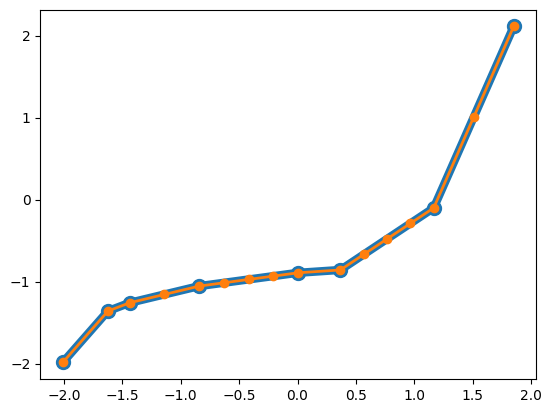

In [17]:
plt.plot(tx[:, 0], tx[:, 1], marker='o', linewidth=6, markersize=10)
plt.plot(tx_ext[:, 0], tx_ext[:, 1], marker='o', linewidth=2, markersize=6)